In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras import models
import glob
import pandas as pd
from PIL import Image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D, Flatten
from livelossplot import PlotLossesKeras


Using TensorFlow backend.


## Загрузка данных

In [2]:
filelist = glob.glob('images/*.png')
data = [[np.array(Image.open(fname).resize((28, 28)).convert('L')).ravel(), int(fname.split('/')[1].split('.')[0])] for fname in filelist]



In [3]:
pd_data = pd.DataFrame(data, columns=['image', 'label'])
pd_data.rename(columns={"label": "boxid"}, inplace=True)
pd_data = pd_data.astype({'boxid': 'int64'})
target = pd.read_csv('./images_labelling.csv')
target = target.astype({'boxid': 'int64'})

## Препроцессинг

In [4]:
all_data = pd.merge(pd_data, target, on='boxid', how='inner')

train_images =np.reshape(np.array(list(map(lambda img: np.reshape(img, (1, 784)), all_data['image']))), (3750,784))
train_target = np.array(all_data['label'])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_target, test_size=0.2, random_state=42)
y_train = np.reshape(y_train.astype(int), (3000, 1))
y_test = np.reshape(y_test.astype(int), (750, 1))
batch_size =len(X_train)

print(X_train.shape, y_train.shape, y_test.shape )

(3000, 784) (3000, 1) (750, 1)


In [6]:
# векторизаця данных
X_train = X_train.reshape(3000, 28, 28, 1)
X_test = X_test.reshape(750, 28, 28, 1)

In [7]:
# приводим таргет фичу к one-hot-encode виду
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
#add model layers
layer_1 = Conv2D(64, kernel_size=3, activation='tanh', input_shape=(28,28,1), name='first_layer')
layer_2 = Conv2D(32, kernel_size=3, activation='tanh', name='second_layer')
layer_3 = Flatten()
layer_4 = Dense(25, activation='softmax')


model = Sequential()
model.add(layer_1)
model.add(layer_2)
model.add(layer_3)
model.add(layer_4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_layer (Conv2D)         (None, 26, 26, 64)        640       
_________________________________________________________________
second_layer (Conv2D)        (None, 24, 24, 32)        18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                460825    
Total params: 479,929
Trainable params: 479,929
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 3000 samples, validate on 750 samples
Epoch 1/3
3000/3000 [==============================] - 12s 4ms/step - loss: 4.4837 - acc: 0.1890 - val_loss: 2.1355 - val_acc: 0.4107
Epoch 2/3
3000/3000 [==============================] - 12s 4ms/step - loss: 1.0426 - acc: 0.6810 - val_loss: 1.5700 - val_acc: 0.4960
Epoch 3/3
3000/3000 [==============================] - 11s 4ms/step - loss: 0.3324 - acc: 0.9287 - val_loss: 1.5655 - val_acc: 0.5387


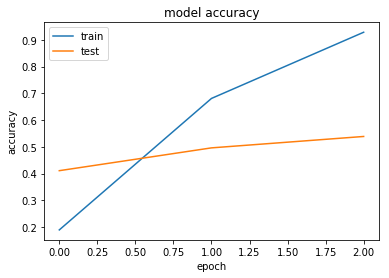

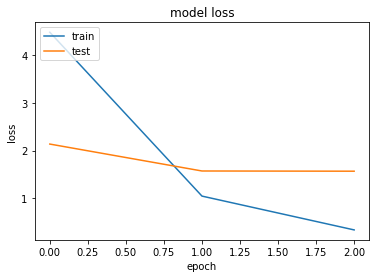

In [10]:
# summarize history for accuracy
# history.history['val_loss']
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
